In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

# 1. Dataset Introduction & Loading

The dataset `short_seasonal.csv` is a synthetic time series created for testing purposes. The data generation process is documented in `src/synthetic_data_generation.ipynb`.

This dataset was designed to be small and computationally lightweight, making it ideal for rapid experimentation. Its short length and strong seasonal pattern introduce unique challenges for data-intensive models, particularly those that struggle with limited training data or insufficient seasonality adaptation.

### Basic Information
- **Granularity:** Monthly
- **Length:** 80 records
- **Features:** Univariate, synthetic seasonality

## Loading the Dataset

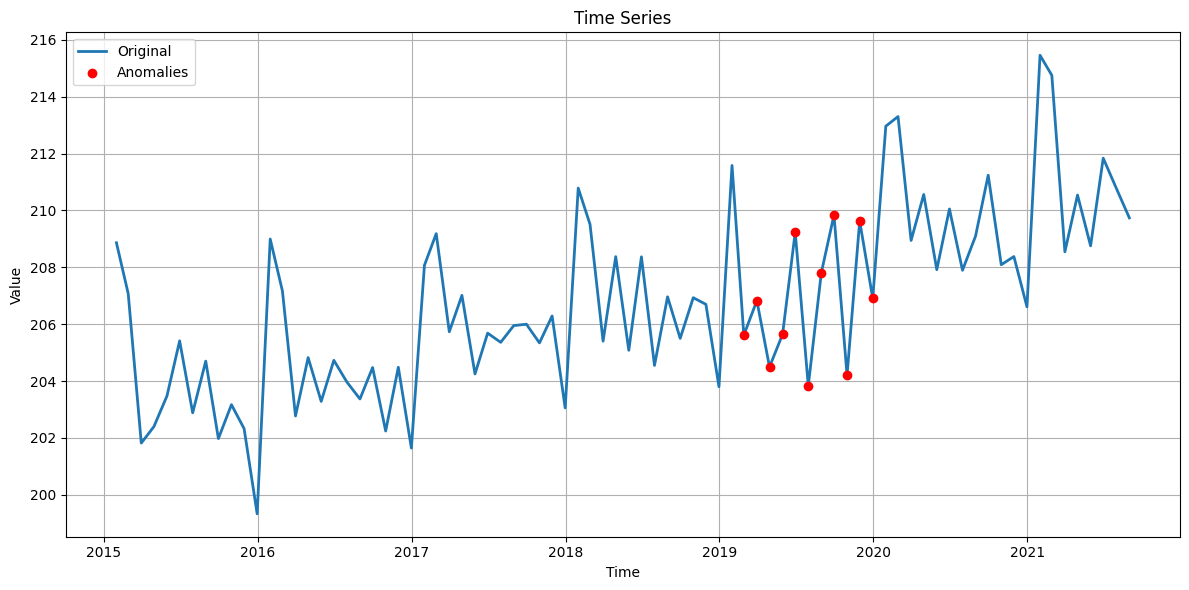

In [2]:
import pandas as pd
from src.synthetic_data.synthetic_data_tools import load_synthetic_data
from src.visualization.plots import plot_ts

data_file = '../data/short_seasonal.csv'

data, ts, labels = load_synthetic_data(data_file)
plot_ts(ts, anom=labels)

# 2.  Classical Statistical Methods

## STL Decomposition 

To begin, STL is applied using `period=12` (yearly seasonality) to separate trend and seasonal components.

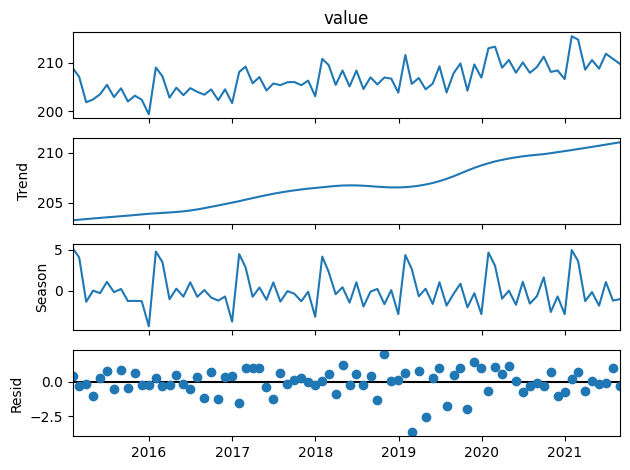

In [3]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts, period=12) 
stl_result = stl.fit()

_ = stl_result.plot()

This decomposition reveals a strong **yearly seasonality** and **linear trend**. Residuals look to have larger variance from late 2018 to late 2019, suggesting a potential for **anomalies**. 

### Linear modeling: 

A linear model is fitted to STL trend.

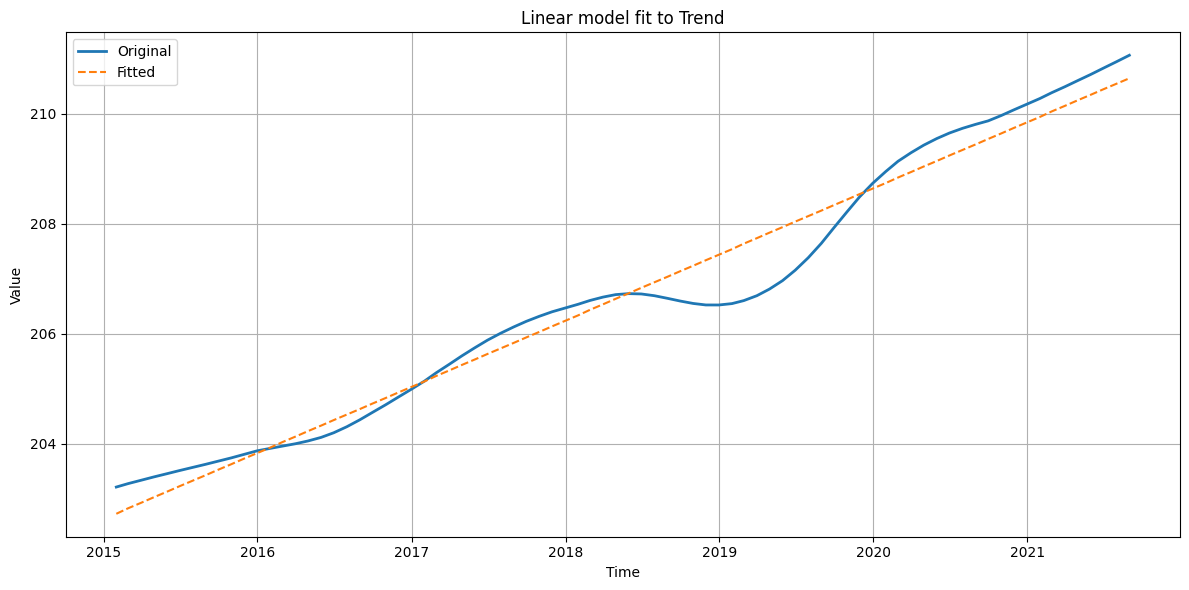

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     2357.
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           4.80e-60
Time:                        14:31:50   Log-Likelihood:                -44.321
No. Observations:                  80   AIC:                             92.64
Df Residuals:                      78   BIC:                             97.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        202.7235      0.094   2145.908      0.0

In [4]:
from src.models.statistical.linear_models import linear_model

lin_model, X = linear_model(stl_result.trend)
lin_results = lin_model.fit()

plot_ts(stl_result.trend, fit=pd.Series(lin_results.predict(X), index=ts.index), title='Linear model fit to Trend')
print(lin_results.summary())

The linear model $(\beta_0+\beta_1 t +r)$ fitted to the STL trend component provides strong evidence that the trend is well-approximated by a linear relationship. All model parameters are statistically significant, with $p$-values effectively equal to $0$, indicating strong evidence against the null hypothesis that any coefficient is zero.

The model achieves a high $R^2$ and adjusted $R^2$ of $0.968$, suggesting that approximately $96.8\%$ of the variation in the trend component is explained by the linear model. These results support the use of a linear trend assumption for this dataset.

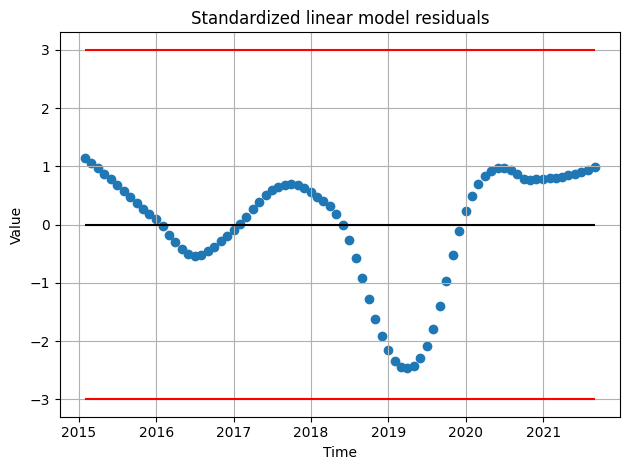

In [5]:
from src.visualization.plots import plot_scatter
from src.models.preprocessing import standardize_residuals

lin_resid = standardize_residuals(pd.Series(lin_results.resid, index=ts.index))
plot_scatter(lin_resid, hlines=[-3, 3], title="Standardized linear model residuals")

The standardized residuals exhibit a clear trend over time, suggesting that the residuals are not independently and identically distributed (i.i.d.) nor normally distributed. This violates key assumptions of linear regression and indicates that the more investigation may be required despite the high $R^2$ values. In this case however, such trend may be due to the STL attributing changes in residuals and seasonality to the trend, and thus will be overlooked.

Notably, the largest deviations between the observed time series and the linear trend occur between late 2018 and late 2019, suggesting a possible change in dynamics or an unmodeled effect during this period.

### Z-scores + CUSUM:

Residuals are standardized and plotted for investigation.

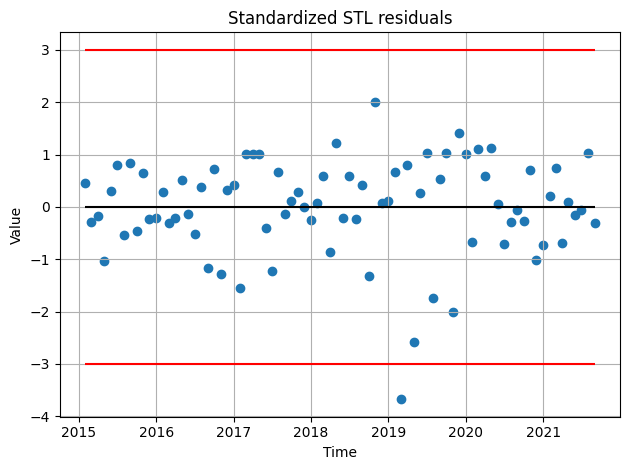

In [6]:
stl_resid = standardize_residuals(pd.Series(stl_result.resid, index=ts.index))
plot_scatter(stl_result.resid, hlines=[-3, 3], title="Standardized STL residuals")

The standardized residuals appear approximately independent and symmetrically distributed around zero, with no visible patterns or clustering over time. Only a single outlier, defined as having $|Z|>3$, is observed in early 2019. This shows that the STL decomposition attributed relatively little changes in the data to the residuals, explaining how the linear residuals do not seem randomly scattered despite strong evidence of linearity.

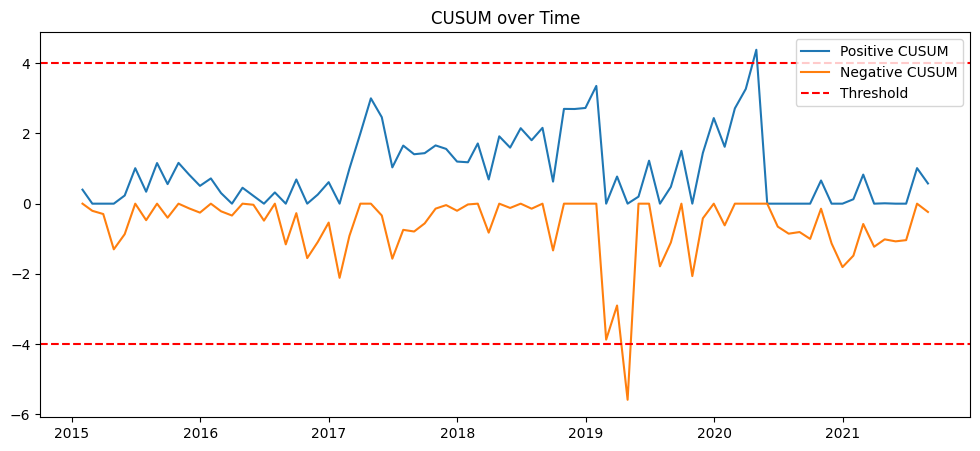

In [7]:
from src.models.statistical.rule_based import cusum

stl_cusum_anom = cusum(stl_resid, plot=True)

The CUSUM chart presents a sudden negative shift in residuals during early 2019, followed by a sudden positive shift in residuals during early 2020. The mean of residuals is less stable during these times periods, suggesting a period of higher volatility and potential anomalies.

## SARIMA Model
### Time Series differencing

Previous analysis indicates that the series exhibits a strong seasonal pattern with a period of 12, along with a positive linear trend. Based on this, it is hypothesized that applying both seasonal and non-seasonal differencing—specifically with parameters $D = 1, d = 1$, and $s = 12$ will yield a stationary time series suitable for SARIMA modeling.


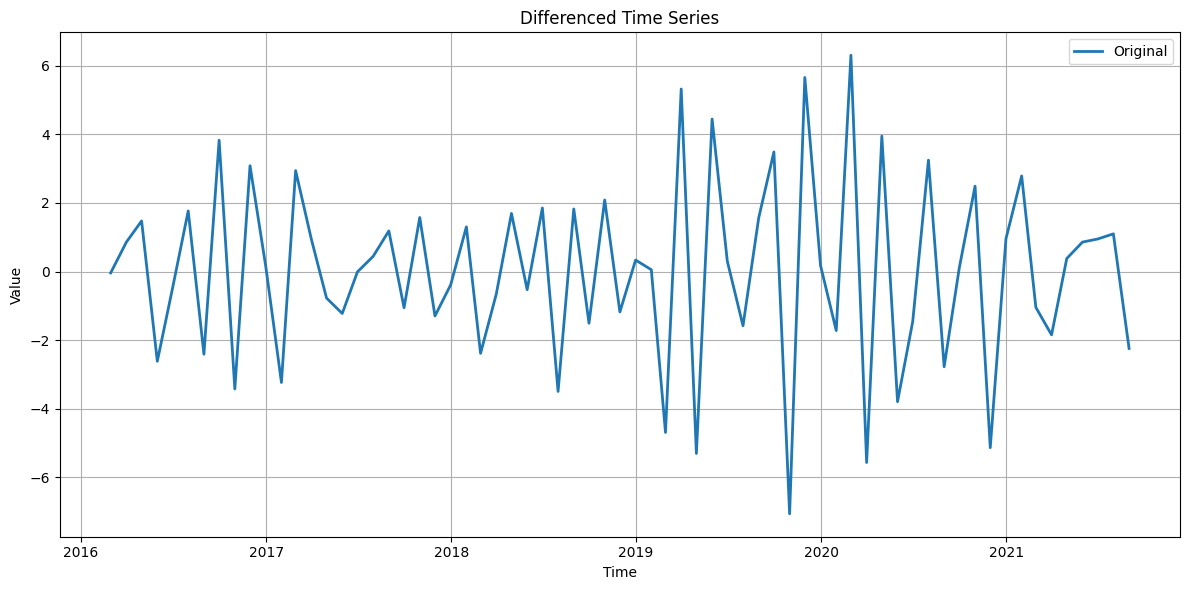

In [8]:
ts_diff = ts.diff(12).diff().dropna()
plot_ts(ts_diff, title='Differenced Time Series')

In [9]:
from statsmodels.tsa.stattools import adfuller

stationary_pval = adfuller(ts_diff.dropna())[1]
print(f'p-value: {stationary_pval}')

p-value: 4.836028218025845e-23


The differenced time series appears to have a constant mean centered around zero, which is a desirable property for stationarity. The $p$-values for the augmented Dickey–Fuller is statistically significant, providing strong evidence that the difference time series is stationary.

However, the variance is not constant over time as there are periods of increased and decreased volatility, suggesting the presence of heteroskedasticity. To check if the differenced times series demonstrates heteroskedasticity, a rolling variance plot is created and an ARCH test is applied.

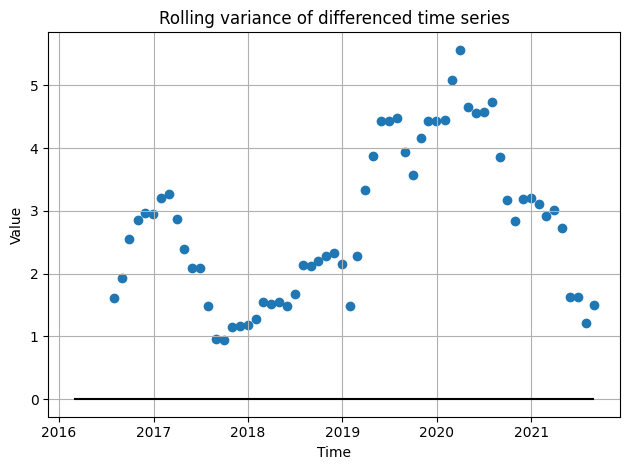

In [10]:
from src.models.statistical.rule_based import rolling_variance
from src.visualization.plots import plot_scatter

window_size = 6
rolling_var = rolling_variance(ts_diff, window=window_size)
plot_scatter(rolling_var, title="Rolling variance of differenced time series")

In [11]:
from statsmodels.stats.diagnostic import het_arch

arch_stat, pval, _, _ = het_arch(ts_diff, nlags=6)
print(f"ARCH test p-value: {pval}")

ARCH test p-value: 0.0023997046998173567


There is a curving trend in the rolling variance and the $p$-value for the ARCH test is statistically significant, presenting strong evidence that heteroskedasticity exists in the time series.

This changing variability violates the assumption of homoskedastic residuals that many time series models, including SARIMA, rely on. As a result, the model may produce unreliable confidence intervals or inefficient parameter estimates.

### SARIMA Model selection

Auto-correlation is calculated on the differenced times series to produce acf/pacf plot for model selection.

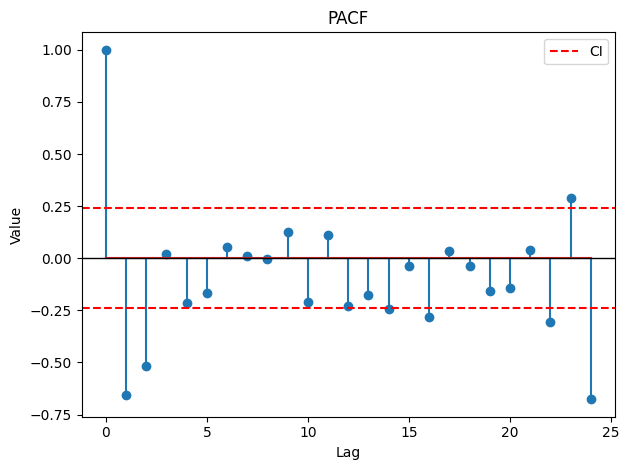

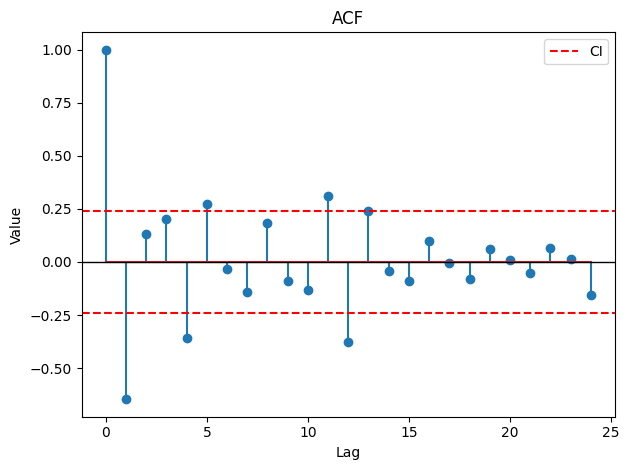

In [12]:
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import norm
from src.visualization.plots import plot_lag_with_ci
import numpy as np

nlags = 24 # Covers 2 periods
pacf_vals = pacf(ts_diff, nlags=nlags)
acf_vals = acf(ts_diff, nlags=nlags, fft=True)

conf_interval = norm.ppf(1 - 0.05 / 2) / np.sqrt(len(ts_diff))
plot_lag_with_ci(pacf_vals, conf_interval, title='PACF')
plot_lag_with_ci(acf_vals, conf_interval, title='ACF')

Neither of the acf or pacf graphs show a clear cut off in the number of lags, such behavior might be explained due to the heteroskedasticity previously observed in the difference time series. 

To continues on with the SARIMA model select, the statistically significant lag of $12$ in acf and the statistically significant lag of $24$ in pacf suggests that $P=2, Q=1$. Similarly, most statistically significant lags appear before $p=5$ and $q=2$, leading to these hyper parameters to be the bases of the SARIMA grid search.

In [13]:
from src.models.statistical.arma_models import SARIMA_grid_search

results_table = SARIMA_grid_search(ts, period=12, d=1, D=1, max_p=5, max_q=2, max_P=2, max_Q=1)
df_results = pd.DataFrame(results_table).sort_values('AIC', na_position='last')

display(df_results[['order', 'seasonal_order', 'AIC', 'BIC']].head(10))

,order,seasonal_order,AIC,BIC
41,"(2, 1, 0)","(2, 1, 1, 12)",12.000000,25.228156
49,"(2, 1, 2)","(0, 1, 1, 12)",259.253896,272.482051
73,"(4, 1, 0)","(0, 1, 1, 12)",259.788058,273.016213
13,"(0, 1, 2)","(0, 1, 1, 12)",260.036414,268.855184
25,"(1, 1, 1)","(0, 1, 1, 12)",260.078275,268.897045
7,"(0, 1, 1)","(0, 1, 1, 12)",260.425185,267.039263
91,"(5, 1, 0)","(0, 1, 1, 12)",260.490071,275.922919
79,"(4, 1, 1)","(0, 1, 1, 12)",260.661320,276.094168
51,"(2, 1, 2)","(1, 1, 1, 12)",260.907050,276.339898
67,"(3, 1, 2)","(0, 1, 1, 12)",261.001091,276.433939


From the top 10 models with the best AIC, the model $SARIMA(2, 1, 0)(2, 1, 1, 12)$ has alarmingly lower AIC and BIC values compared to all others models. As such the model is plotted below for further investigation. 

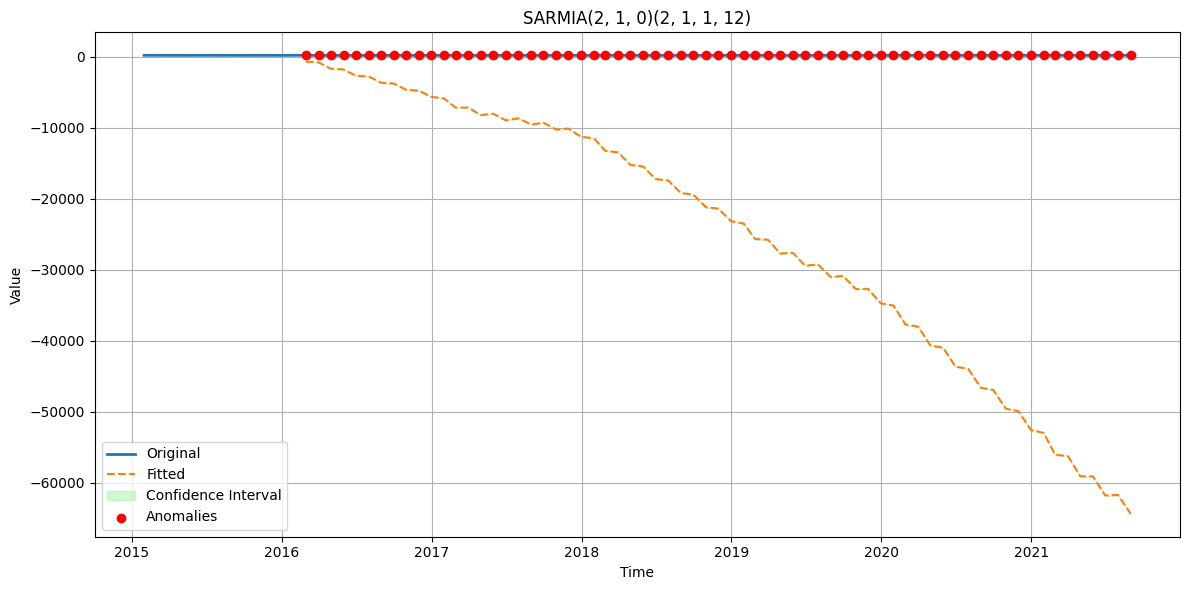

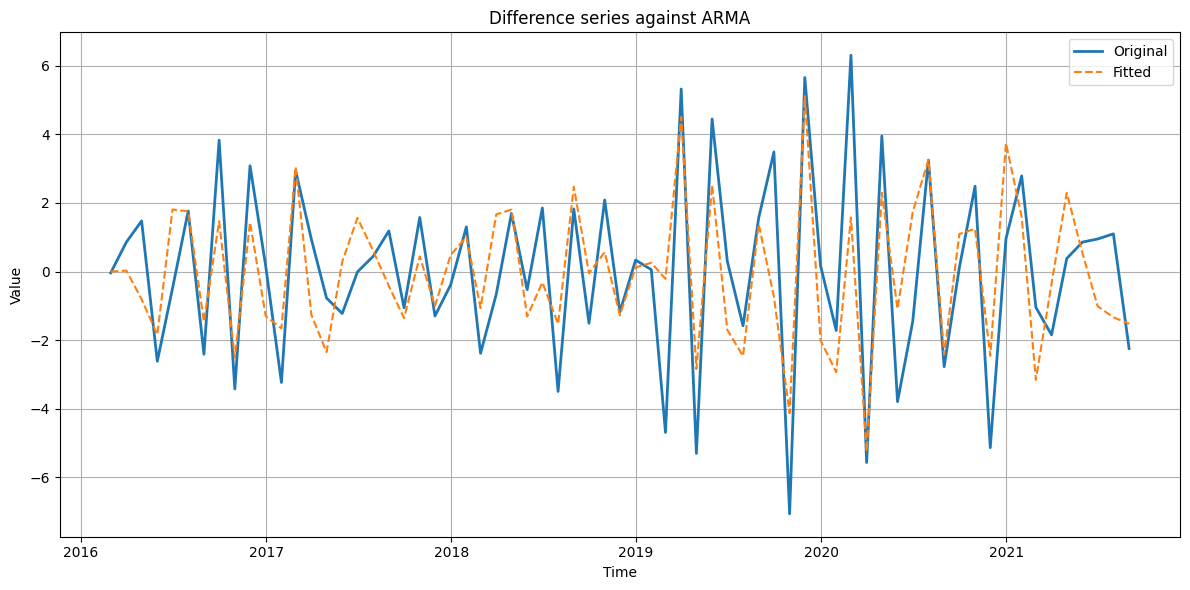

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

best_sarima_model = df_results.iloc[0]
plot_ts(ts, fit=best_sarima_model['model'].fittedvalues[13:], CI=best_sarima_model['conf_int'], 
        anom=best_sarima_model['anom'], title=f'SARMIA{best_sarima_model['order']}{best_sarima_model['seasonal_order']}')

model = SARIMAX(ts_diff, order=(2, 0, 0), freq='ME').fit()
plot_ts(ts_diff, fit=model.fittedvalues, title='Difference series against ARMA')

While the $SARIMA(2,1,0)(2,1,1,12)$ model achieved the lowest AIC and BIC, its fitted values **diverged drastically** from the original data. This discrepancy might be explained by AIC/BIC values computed based on the model's fit to the **differenced series**, not the original scale. Though the model fits the differenced data well, the inverse transformation compounds errors due to its autoregressive structure, resulting in an implausible fit. This highlights the limitations of using information criteria alone for model selection.

The 9 other models do not differ greatly in AIC and BIC values, resulting in $SARMIA(0, 1, 1)(0, 1, 1, 12)$ selected in preference of model simplicity.

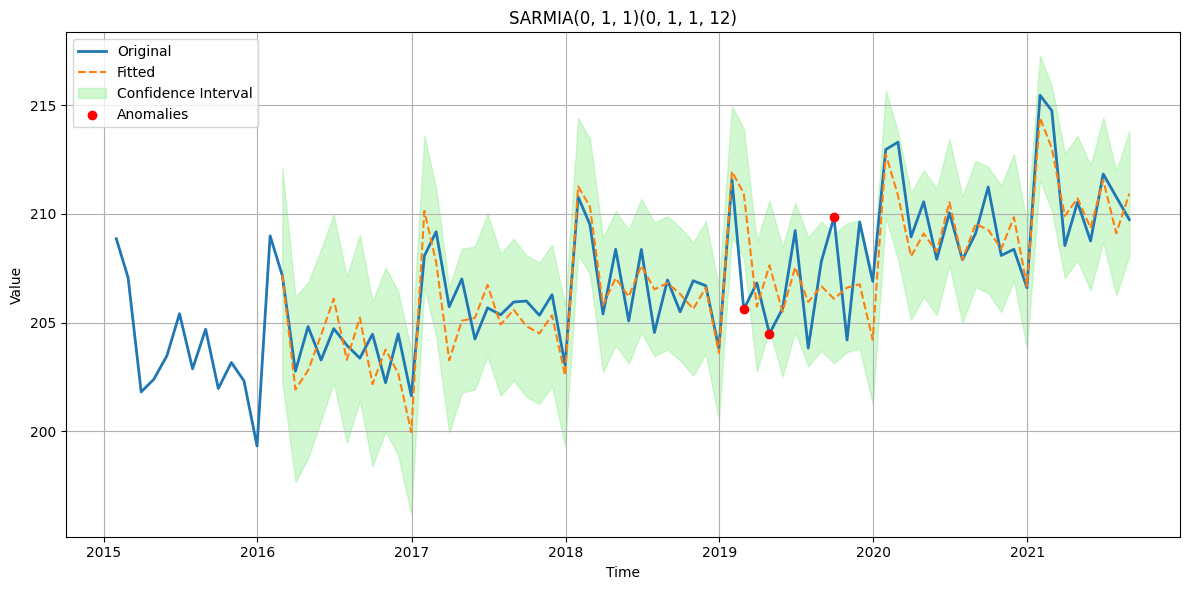

In [21]:
best_sarima_model = df_results.iloc[5]
plot_ts(ts, fit=best_sarima_model['model'].fittedvalues[13:], CI=best_sarima_model['conf_int'], 
        anom=best_sarima_model['anom'], title=f'SARMIA{best_sarima_model['order']}{best_sarima_model['seasonal_order']}')

Using the $95\%$ confidence interval, 3 prediction anomalies are identified using the selected model, all of which lie in the calendar year 2019.

### Across model Anomalies

Since the top 10 models do not differ significantly in terms of AIC and BIC, one may also consider the number of models that marked each point as a prediction anomaly.

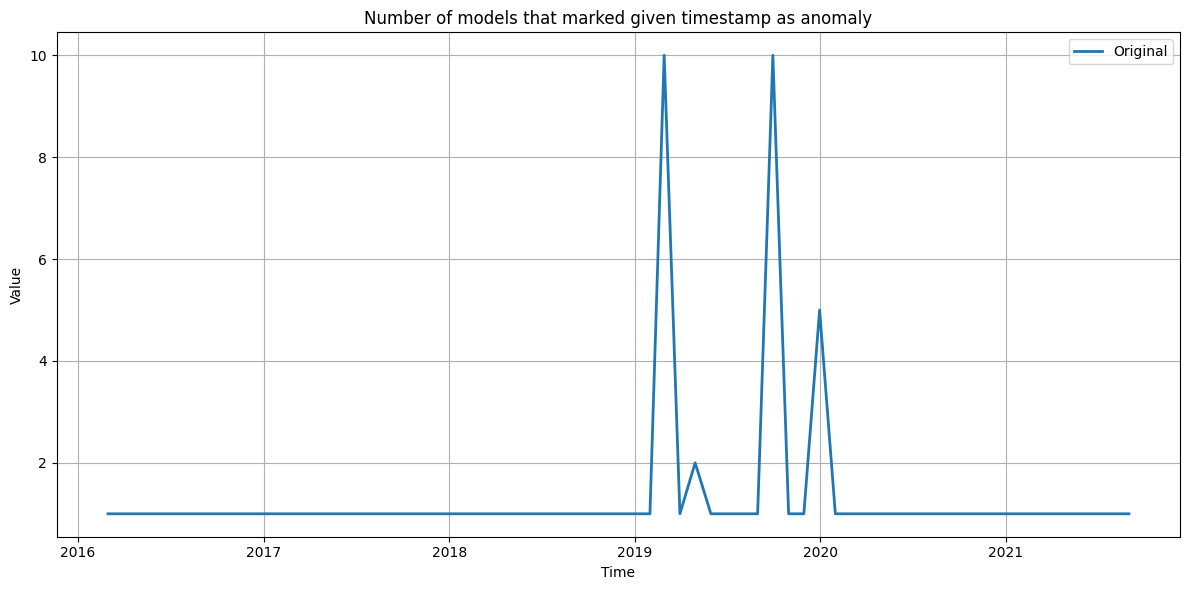

In [26]:
from src.models.statistical.arma_models import count_anoms

anom_counts = count_anoms(df_results[['anom']].head(10))
plot_ts(anom_counts, title='Number of models that marked given timestamp as anomaly')

Models have a significantly harder time predicting data from early 2019 to early 2020. Specifically, all of the top 10 models failed to predict the values at Feb 2019 and Sept 2019.

# 3 Self-trained Machine Learning models

## LSTM Autoencoder

### Complex model
A LSTM model with `hidden_dim=8` is fitted to the time series.

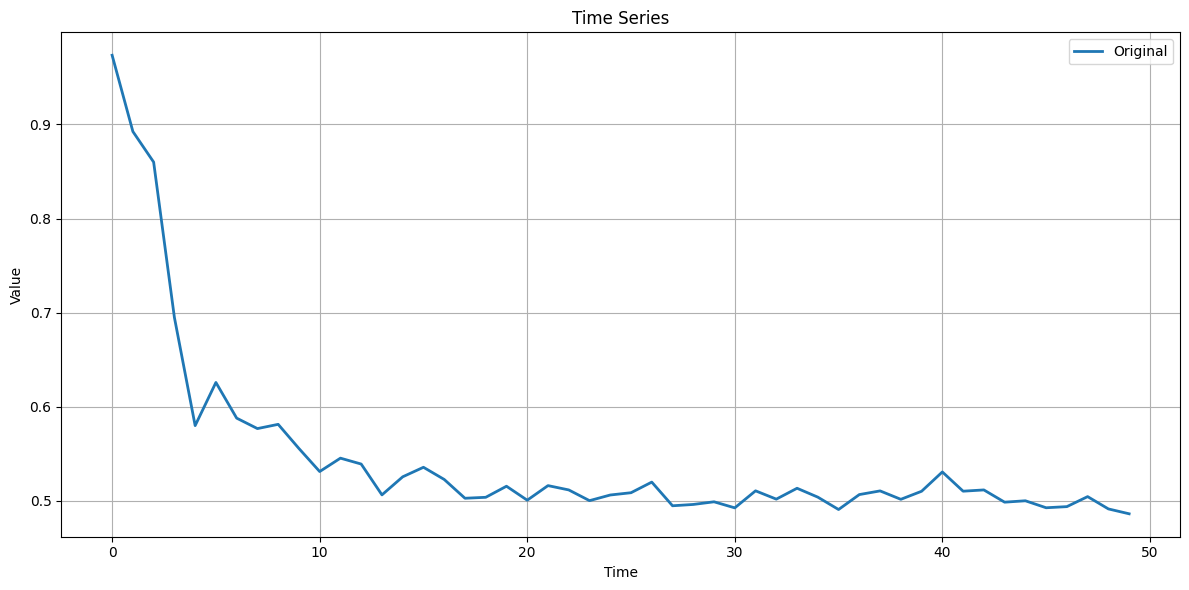

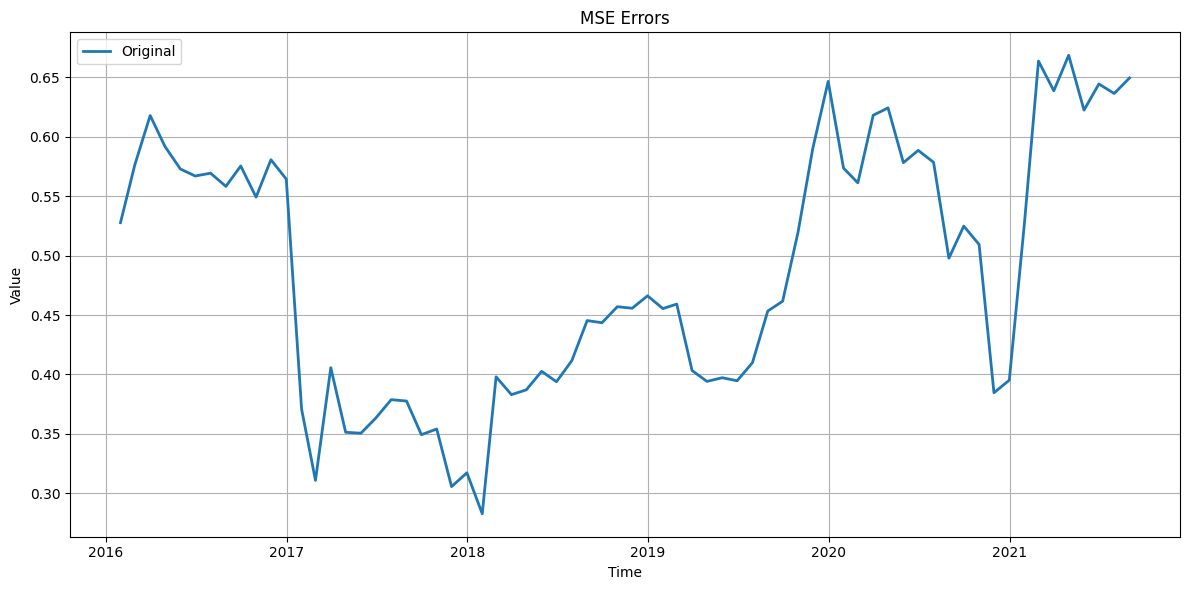

In [ ]:
from src.models.self_trained_ml.lstm_ae import model_LSTMAE

mse_LSTM = model_LSTMAE(ts, window_size=12, batch_size=16, hidden_dim=8, latent_dim=8, learning_rate=0.01, epochs=50, plot_accuracy=True)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[12:])
plot_ts(errors_ts, title='MSE Errors')

The same model is trained on `epochs=10` (the elbow of the accuracy plot) to avoid over fitting.

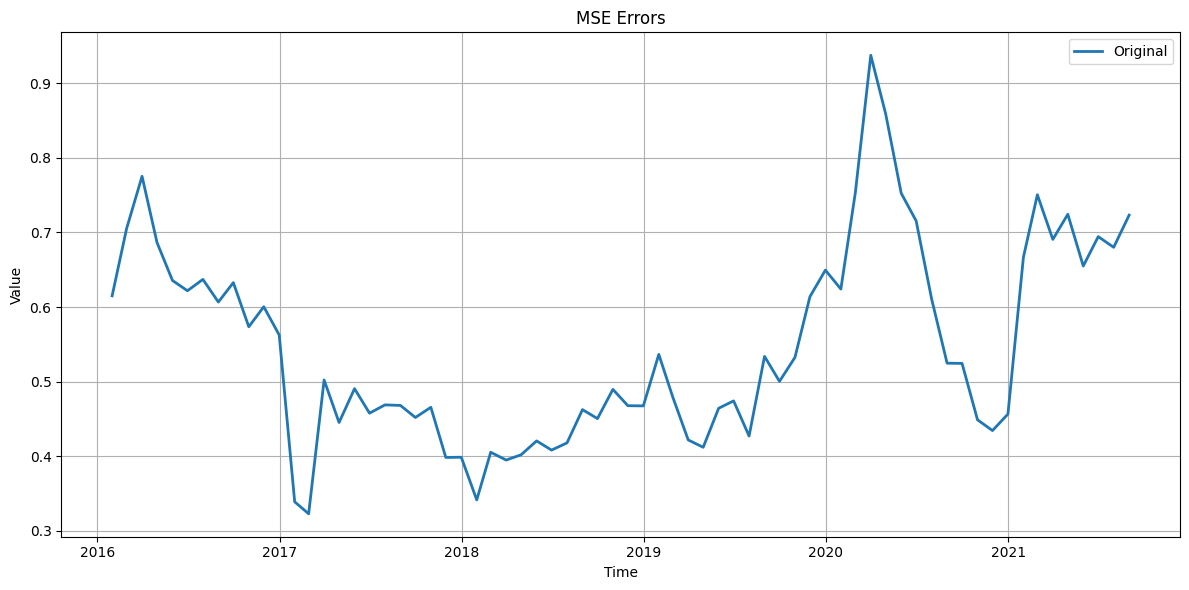

In [4]:
mse_LSTM = model_LSTMAE(ts, window_size=12, batch_size=16, hidden_dim=8, latent_dim=8, learning_rate=0.01, epochs=10)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[12:])
plot_ts(errors_ts, title='MSE Errors')

### Simple model
A LSTM model with `hidden_dim=2` is fitted to the time series.

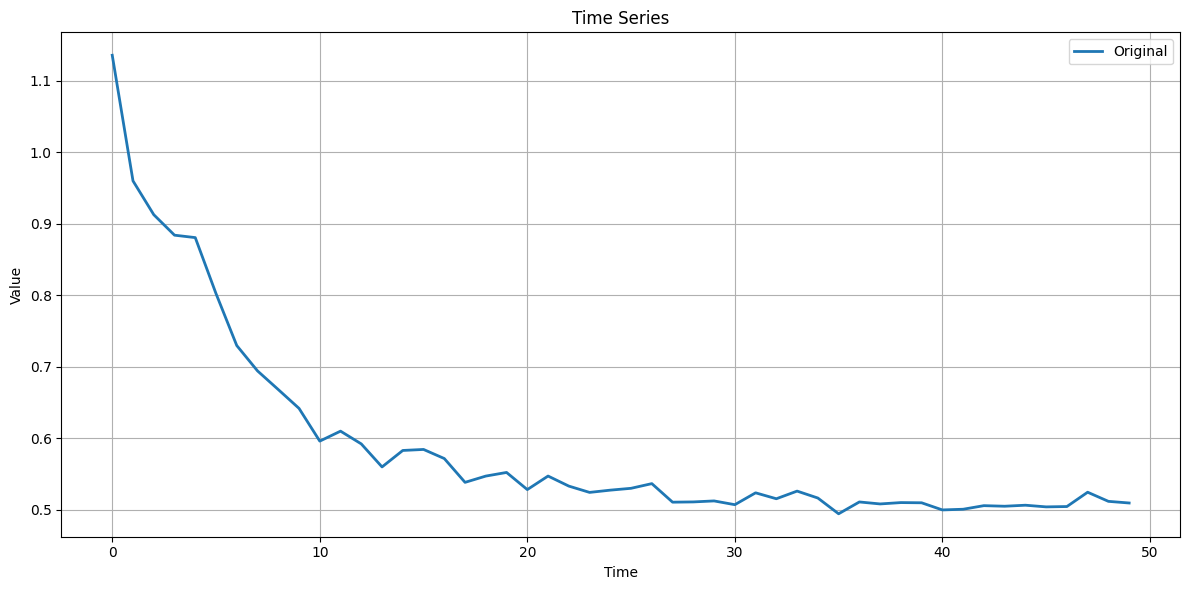

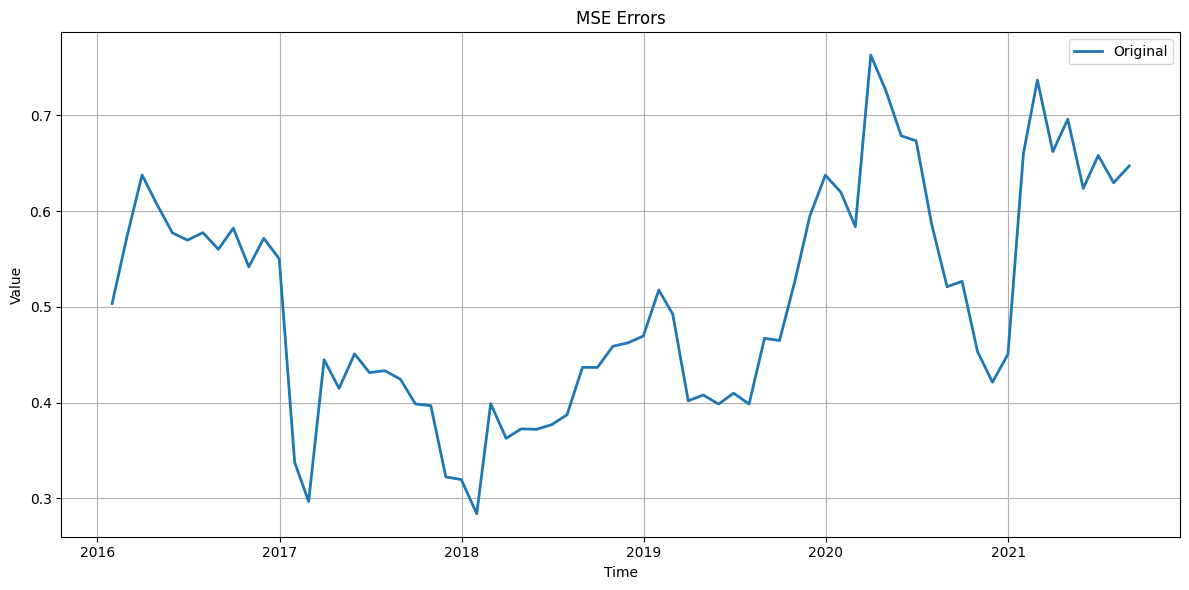

In [6]:
mse_LSTM = model_LSTMAE(ts, window_size=12, batch_size=16, hidden_dim=2, latent_dim=2, learning_rate=0.01, epochs=50, plot_accuracy=True)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[12:])
plot_ts(errors_ts, title='MSE Errors')

The same model is trained on `epochs=16` (the elbow of the accuracy plot) to avoid over fitting.

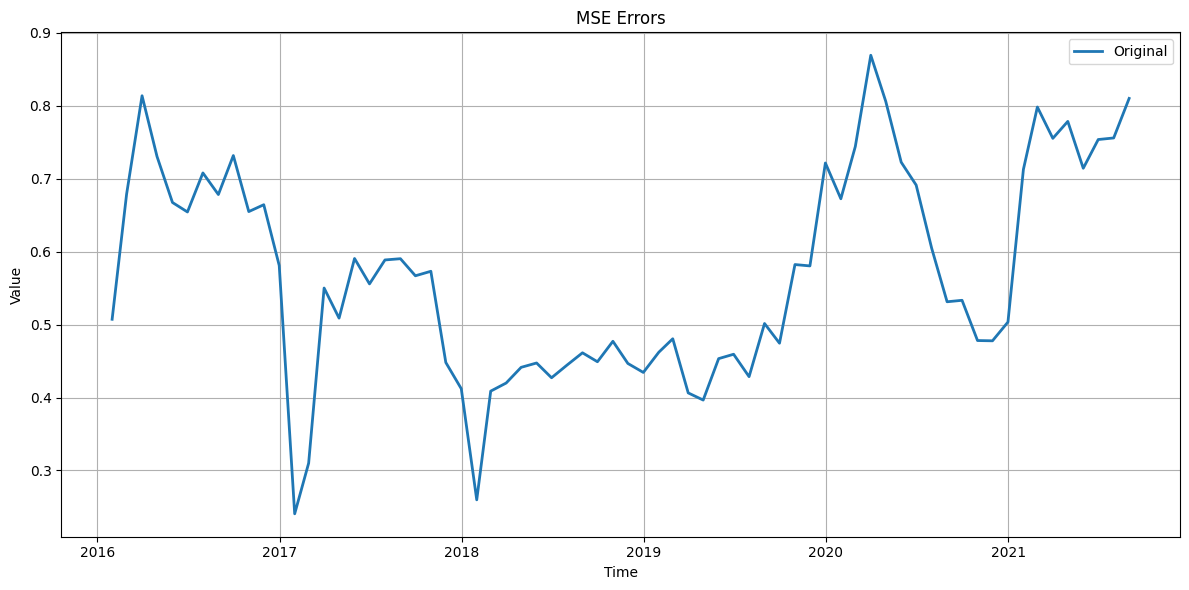

In [10]:
mse_LSTM = model_LSTMAE(ts, window_size=12, batch_size=16, hidden_dim=2, latent_dim=2, learning_rate=0.01, epochs=16)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[12:])
plot_ts(errors_ts, title='MSE Errors')

### LSTM Comparisons

Both the complex model (`hidden_dim=8`) and the simple model (`hidden_dim=2`) converge to a similar training loss of approximately $0.5$, indicating **no substantial difference** in their reconstruction capabilities.

In terms of anomaly detection behavior, both models exhibit similar error patterns:
- Mean squared error (MSE) peaks notably in early 2020,
- With additional elevated errors observed in 2016 and 2021.

These similarities suggest that increasing the model complexity **did not** lead to meaningful performance gains for this dataset.

## Isolation Forest

### Standard Features

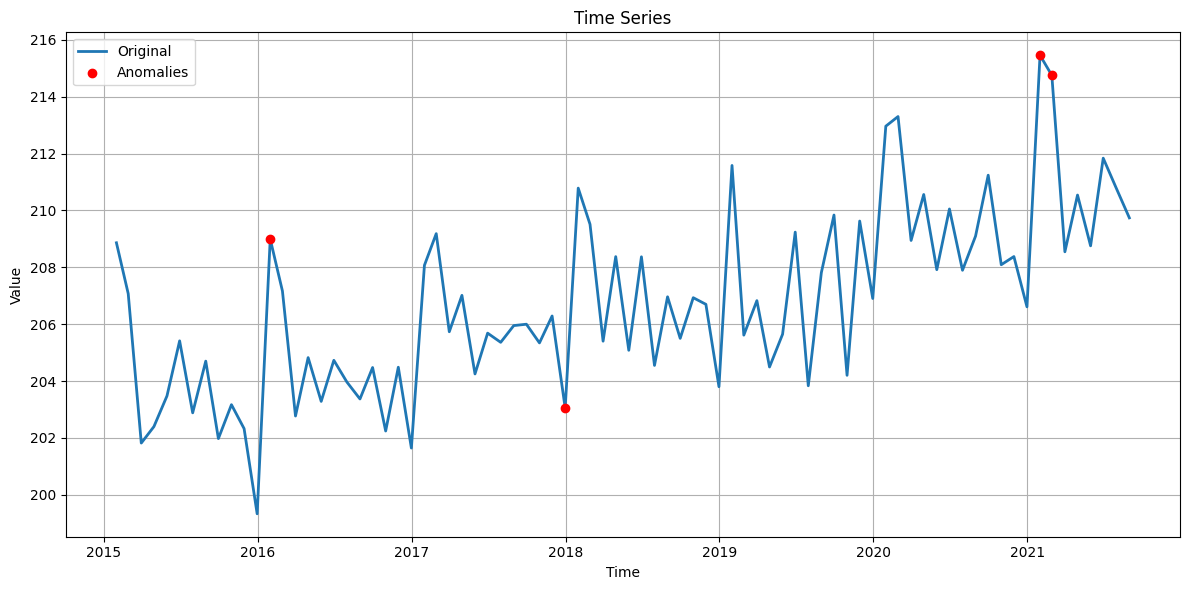

In [13]:
from src.models.self_trained_ml.isolation_forest import model_isolation_forest
import numpy as np

def extract_features(windows) -> pd.DataFrame:
    features = []
    for w in windows:
        w = pd.Series(w)
        f = {
            'mean': w.mean(),
            'std': w.std(),
            'min': w.min(),
            'max': w.max(),
            'skew': w.skew(),
            'kurt': w.kurt(),
            'slope': np.polyfit(np.arange(len(w)), w.values, 1)[0],
        }
        features.append(f)
    return pd.DataFrame(features)

if_results = model_isolation_forest(ts, extract_features=extract_features, window_size=12)
plot_ts(ts, anom=if_results['anomaly'])

There is no clear clustering among the anomalies identified by the Isolation Forest. However, all four detected anomalies occur near seasonal peaks or troughs, suggesting that the model may be responding primarily to **normal seasonal variation**. This indicates that better feature engineering or seasonality-aware representations may be needed for more meaningful anomaly detection on this dataset.

### Seasonal Features
The following extract features function is modified to be more seasonality aware.

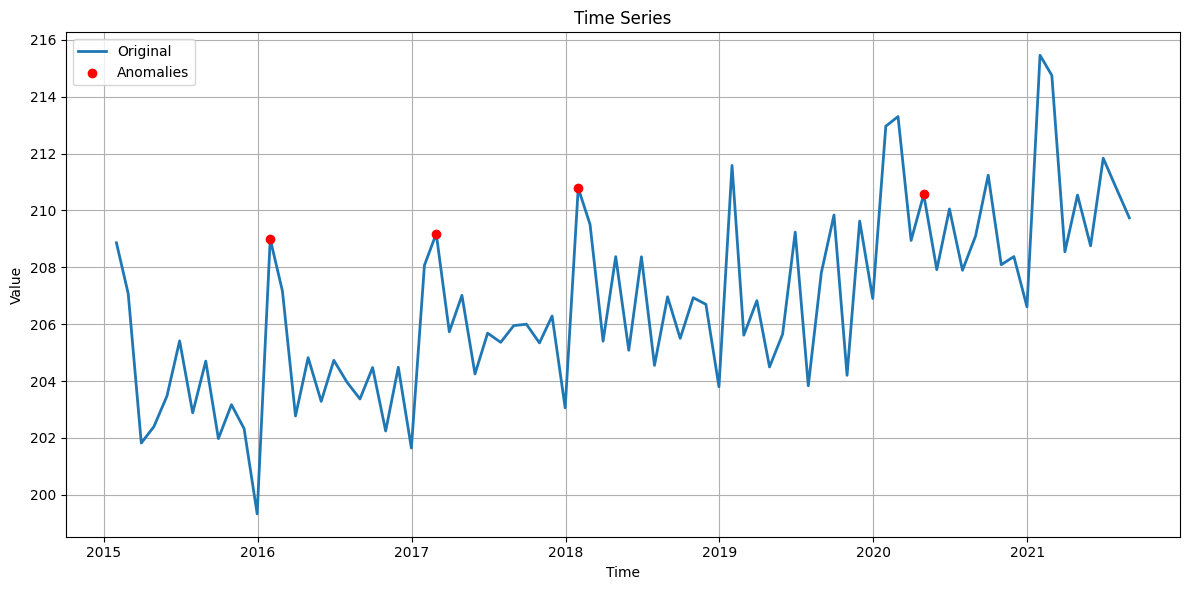

In [14]:
def extract_features(windows) -> pd.DataFrame:
    features = []

    for w in windows:
        w = pd.Series(w)
        fft = np.fft.rfft(w - w.mean())
        f_abs = np.abs(fft)

        f = {
            'mean': w.mean(),
            'std': w.std(),
            'min': w.min(),
            'max': w.max(),
            'skew': w.skew(),
            'kurt': w.kurt(),
            'slope': np.polyfit(np.arange(len(w)), w.values, 1)[0],
            
            'acf_lag_1': w.autocorr(lag=1),
            'acf_lag_12': w.autocorr(lag=12) if len(w) >= 13 else 0,
            'fft_seasonal_power': f_abs[1] if len(f_abs) > 1 else 0,
            'fft_total_power': f_abs.sum(),
            'fft_ratio': f_abs[1]/f_abs.sum() if f_abs.sum() > 0 and len(f_abs) > 1 else 0,
        }

        features.append(f)

    return pd.DataFrame(features)

if_results = model_isolation_forest(ts, extract_features=extract_features, window_size=12)
plot_ts(ts, anom=if_results['anomaly'])

Similarly to the previous model, there is no clear clustering among the anomalies identified by the Isolation Forest. The identified anomalies also occur more often at the peaks of seasonality showing that this model does not preform well with strongly seasonal data.

# 4 Pretrained Models

## Prophet

c:\Users\tangj\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
09:54:22 - cmdstanpy - INFO - Chain [1] start processing
09:54:23 - cmdstanpy - INFO - Chain [1] done processing


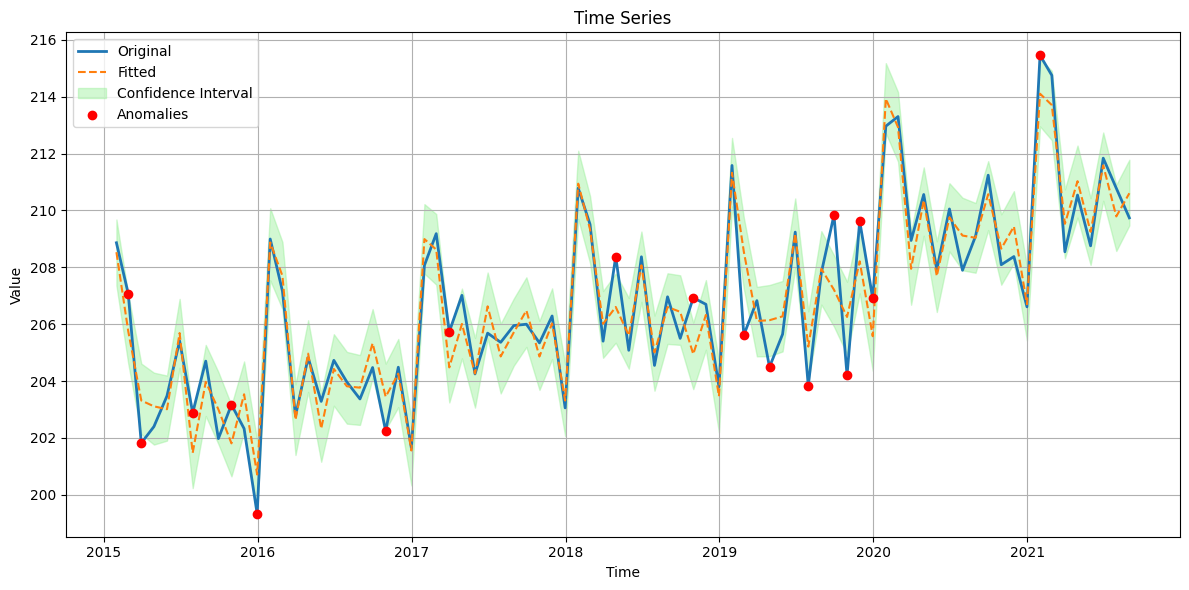

In [ ]:
from prophet import Prophet
from src.visualization.plots import plot_ts

prophet_df = pd.DataFrame({
    'ds': ts.index,  
    'y': ts.values 
})

model = Prophet()
model.fit(prophet_df)

prophet_pred = model.predict(prophet_df[['ds']].copy())

prophet_anom = (prophet_df['y'] < prophet_pred['yhat_lower']) | (prophet_df['y'] > prophet_pred['yhat_upper'])
prophet_anom = pd.Series(prophet_anom.values, index=ts.index)

prophet_CI = prophet_pred[['yhat_lower', 'yhat_upper']].copy()
prophet_CI.index = ts.index

plot_ts(ts, pd.Series(prophet_pred['yhat'].values, index=ts.index), CI=prophet_CI, anom=prophet_anom)

The prediction anomalies cluster in years 2015 and 2019, suggesting the time frames where the anomalies lie. Interestingly, the Prophet model identified much more prediction anomalies compared to the SARIMA models in section 2.

### Z-scores

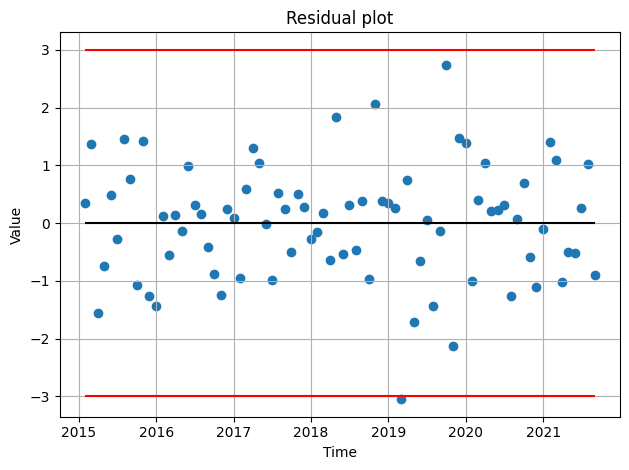

In [ ]:
from src.visualization.plots import plot_scatter
from src.models.preprocessing import standardize_residuals

prophet_resid = standardize_residuals(pd.Series(prophet_df['y'].values - prophet_pred['yhat'].values, index=ts.index))
plot_scatter(prophet_resid, hlines=[-3, 3])

The standardized residuals are evenly scattered around the x-axis, with a single outlier occurring at Feb 2019. 

# 4. Summary & Comparisons 

None of the models tested above were perfect in identifying the exact anomalies in the `short_seasonal` dataset. However, most were able to highlight regions of potential concern, offering useful insights into the data's behavior.

Encouragingly, **all models** except Isolation Forest flagged unusual behavior during 2019, which aligns with the known anomalies in the dataset.

The table below summarizes each model’s performance based on two criteria:
- Whether it correctly identified the known anomalies
- Whether it mistakenly flagged normal regions as anomalous


|Model|Anomalies Detected | False Positives|
|-------|-------------------------------|------------------|
|STL + Z-scores| Partially detected | None |
|STL + CUSUM| Partially detected| Some false positives|
|SARIMA + Prediction | Partially detected | None|
|SARIMA + Anomaly count| Partially detected | None |
|LSTM-AE | Largely detected | Some false positives |
|Isolation forest| Not detected | Some false positives |
|Prophet | Largely detected | Some false positives|